In this first part, we first work on french articles taken from different websites.

We first downloaded a [dataset](https://webz.io/free-datasets/french-news-articles/) which contained 245 308 french articles published in 2016 taken from different publishers.

From this dataset, we picked about 15 000 articles which come from traditional news websites. These picked articles formed the dataset we worked on during our project.



#Imports

In [ ]:
from IPython.display import clear_output
!pip install torchinfo
!pip install transformers[sentencepiece]
clear_output()

In [ ]:
import glob
import json
import re
import pickle
import os
import shutil
import functools
import torch
import gdown
import time
import nltk
import string

import numpy as np
import random as rd
import pandas as pd

from math import log
from collections import defaultdict,Counter
from pathlib import Path

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.corpus import wordnet as wn

from transformers import CamembertModel, CamembertTokenizer
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

from torchtext.vocab import FastText,vocab
from torch.utils.data import Dataset,DataLoader
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import random_split

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw.zip.


True

#Global functions

##Json files

Functions to handle json files

In [ ]:
def read_json(file_path):
  '''Read Json file from path
  file_path : string, path to json file'''
  with open(file_path,encoding='utf-8') as f:
    json_file=json.load(f)
  return(json_file)

In [ ]:
def save_json(file_path,data):
  '''Save Json file to path
  file_path : string, destination path (ex /user/json_file.json)
  data : dictionnary to be saved as json file'''
  with open(file_path,"w") as save_file :
      save_file.write(json.dumps(data))
  return None

##Download whole article dataset

Download $\approx$ 250000articles dataaset from drive

In [ ]:
!gdown  https://drive.google.com/uc?id=1kf2wHibUsD118swso0_oWbuqtVj5nItT

In [ ]:
#@title unziping dataset file
!mkdir "/content/data"
!unzip "/content/newspapers.zip" -d "/content/data"
!unzip "/content/data/636_webhose-2016-10_20170904085710.zip" -d "/content/data"
clear_output()

In [ ]:
#Retrieve paths to all articles
articles_paths=glob.glob("/content/data/*.json")

In [ ]:
print("Path example : \n", articles_paths[0])
print("Number of articles :\n",len(articles_paths))

Path example : 
 /content/data/news_0078951.json
Number of articles :
 245308


##Tokenizer

Simple regular expression based tokenizer which tokenizes based on non alpha numeric characters, and which handles contractions : it tokenizes "d'une" as "de" and "une", "j'ai" as "je" and "ai" ...

In [ ]:
tokenizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''') #regexp based tokenizer

#tokenizer function
def tokenize_sentence(sentence: str,tokenizer: RegexpTokenizer):
  '''Simple tokenizer, removes or replaces special characters
  sentence : str sentence to be tokenized
  tokenizer : tokenizer with tokenize method '''

  #Lower capital leters
  tokenized=sentence.lower()
  #Change special character
  tokenized=re.sub("’","'",tokenized)
  #Remove unwanted characters
  tokenized=re.sub("(@\w*\\b\s?|#\w*\\b\s?|&\w*\\b\s?|\n\s?|\\\\|\<|\>|\||\*)","",tokenized)
  tokenized=re.sub("\/","",tokenized)
  #Replace articles since model does not embed contractions well
  tokenized=re.sub("l'","le ",tokenized)
  tokenized=re.sub("d'","de ",tokenized)
  tokenized=re.sub("j'","je ",tokenized)
  tokenized=re.sub("qu'","que ",tokenized)
  tokenized=re.sub("t'","te ",tokenized)
  tokenized=re.sub("c'","ce ",tokenized)
  #Tokenize sentence
  tokenized=tokenizer.tokenize(tokenized)
  return(tokenized)

In [ ]:
def test_tokenizer(tokenize_sentence, tokenizer, paths, nb_tests):
  for i in range(nb_tests):
    path=rd.choice(paths)
    file_text=read_json(path)["text"]
    tokenized=tokenize_sentence(file_text, tokenizer)
    print(tokenized)
  return None

In [ ]:
test_tokenizer(tokenize_sentence,tokenizer,articles_paths,5)

['gap', 'sébastien', 'ogier', 'quadruple', 'champion', 'du', 'monde', 'des', 'rallyes', 'le', 'gapençais', 'sébastien', 'ogier', 'est', 'quadruple', 'champion', 'du', 'monde', 'des', 'rallyes', 'après', 'sa', 'victoire', 'en', 'wrc', 'dimanche', 'en', 'espagne', '.', 'par', 'mariella', 'coste', '©', 'nikos', 'mitsourasepamaxppp', 'ogier', 'quadruple', 'champion', 'du', 'monde', 'le', 'pilote', 'gapençais', 'sébastien', 'ogier', 'avec', 'son', 'co', '-', 'pilote', 'le', 'aixois', 'julien', 'ingrassia', 'a', 'fait', 'coup', 'double', 'aujourde', 'hui', '!', 'il', 'a', 'remporté', 'le', 'rallye', 'de', 'catalogne', ',', 'et', 'du', 'même', 'coup', 'le', 'titre', 'de', 'champion', 'du', 'monde', 'des', 'rallyes', ',', 'ce', 'est', 'sa', 'quatrième', 'couronne', '.', 'ce', 'est', 'fantastique', '.', 'ce', 'était', 'une', 'saison', 'difficile', 'mais', 'je', 'ai', 'toujours', 'pu', 'compter', 'sur', 'une', 'voiture', 'parfaite', "s'", 'est', 'réjoui', 'ogier', 'au', 'point', 'stop', 'de', 'l

#Description of the orignal dataset

In this part, we take a look at the different articles present in the original dataset (the one containing $\approx$ 250 000 articles) and we sample $\approx$ 16000 articles that will form the dataset we will work/train with.

##First take a look at the distribution of publishers in our dataset

###Functions to get to know the distribution of publishers in the original dataset

In this dataset, there are articles published by different publishers. Since we want to use news articles, we need to select the publisher who publish these news articles (and not ads for ex).

In [ ]:
def get_website(article_json,path=False):
  '''Returns website in which the article was published
  article_json : either str which contains path of article or dictionnary
  path : Boolean, true if article_json contains path to article and False otherwise'''
  if path:
    article=read_json(article_json)
  else:
    article=article_json
  try:
    website=article["thread"]["site"].split(".")[0]
  except:
    website=""
  return(website)

In [ ]:
#Dictionnary with as keys the path to the articles and as value the website in which it was published
articles_web={}
#Number of articles for each website in our dataset
nb_websites=defaultdict(int)
#Dictionnary with as key a website and as value a list which contains the paths to all the articles
#published in this website
list_of_articles_per_website=defaultdict(list)

for article in tqdm(articles_paths):
  #get website in which the article was published:
  website=get_website(article,True)
  articles_web[article]=website
  nb_websites[website]+=1
  list_of_articles_per_website[website].append(article)


100%|██████████| 245308/245308 [00:18<00:00, 13189.68it/s]


In [ ]:
save_json("/content/website_for_each__article.json",articles_web)
save_json("/content/nb_published_per_websites.json",nb_websites)
save_json("/content/paths_to_articles_per_website.json",list_of_articles_per_website)

Sort publishers by number of published articles

In [ ]:
sorted_articles=sorted(nb_websites, key=nb_websites.get, reverse=True)
sorted_articles_dict={web:nb_websites[web] for web in sorted_articles}

In [ ]:
print(sorted_articles_dict)

{'anibis': 73756, 'yahoo': 15850, 'orange': 11743, 'francetvinfo': 11385, 'dhnet': 10767, 'leparisien': 8752, 'lexpress': 7947, 'lefigaro': 7653, 'lapresse': 6724, 'ladepeche': 4926, 'europe1': 4712, '7sur7': 4332, 'lesoir': 4110, 'lepoint': 3879, 'lequipe': 3854, 'lesechos': 3650, 'lemonde': 3646, 'nouvelobs': 3572, 'huffingtonpost': 3459, 'metronews': 2976, '20minutes': 2942, 'lavenir': 2939, 'dealabs': 2839, 'bfmtv': 2785, 'beinsports': 2729, 'melty': 2700, 'footmercato': 1756, 'maxifoot': 1742, 'liberation': 1650, 'eurosport': 1647, 'sputniknews': 1449, 't411': 1272, 'rtl': 1206, 'purepeople': 1047, 'motorsport': 947, 'sudouest': 915, 'timesofisrael': 809, 'sncf': 764, 'free': 737, 'rfi': 706, 'gentside': 606, 'businesswire': 565, 'xinhuanet': 564, 'elle': 555, 'euronews': 506, 'linternaute': 503, 'gouv': 492, 'ldlc': 491, 'aufeminin': 489, 'france24': 460, 'europa': 453, 'lesnumeriques': 448, 'ea': 444, 'rueducommerce': 427, 'wn': 423, 'prnewswire': 417, 'dailymotion': 386, 'journ

###Plot of the distribution of publishers

we plot below the number of published articles in our dataset per publisher

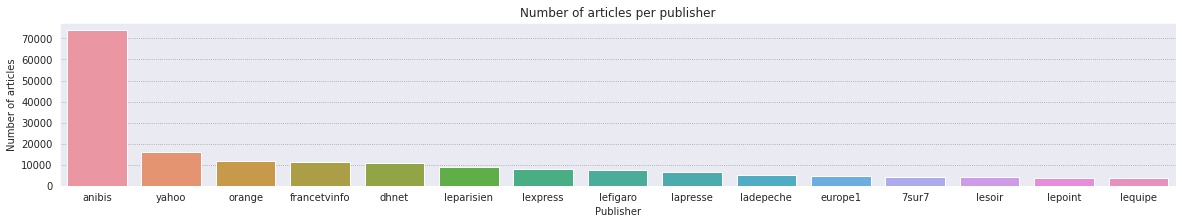

In [ ]:
#@title Plot of the distribution of publishers


x=list(sorted_articles_dict.keys())[:15]
y=list(sorted_articles_dict.values())[:15]
plt.figure(figsize=(20, 3))
sns.barplot(x=x,y=y).set(title="Number of articles per publisher")
plt.ylabel("Number of articles")
plt.xlabel("Publisher")
plt.show()

## Save a subsampled version of the full dataset with articles taken from publishers of interest

As mentionned, in this dataset, the contents of a given article depends heavily on the publisher. For instance the articles published in "anibis" mainly consist in offers/ads published by internet users, whereas the articles published in more traditional news providers (yahoo, francetvinfo ..) contain news. 

For that reason, we will restrain our study to the articles which are published by the following list of handpicked publishers :

In [ ]:
#@title Publisher which articles we consider.
selected_publishers=list(sorted_articles_dict.keys())[1:29]
selected_publishers.remove("lequipe")
selected_publishers.remove("beinsports")
selected_publishers.remove("footmercato")
selected_publishers.remove("maxifoot")
selected_publishers.remove("dealabs")
print(selected_publishers)

['yahoo', 'orange', 'francetvinfo', 'dhnet', 'leparisien', 'lexpress', 'lefigaro', 'lapresse', 'ladepeche', 'europe1', '7sur7', 'lesoir', 'lepoint', 'lesechos', 'lemonde', 'nouvelobs', 'huffingtonpost', 'metronews', '20minutes', 'lavenir', 'bfmtv', 'melty', 'liberation']


In [ ]:
#list storing the paths to all the articles published by a publisher of interest
paths_of_interest=[]

for publisher in selected_publishers:
  #add all articles published by publisher to list
  paths_of_interest+=list_of_articles_per_website[publisher]

In [ ]:
with open("paths_to_articles_of_interest.pickle","wb") as f:
  pickle.dump(paths_of_interest,f)

In [ ]:
#Now choose the 15000 articles (+1000 since we will prune out articles with not enough characters) which we will use :
np.random.seed(0)
articles_dataset=(np.random.choice(paths_of_interest,size=16000,replace=False)).tolist()

In [ ]:
with open("final_articles_dataset_path.pickle","wb") as f:
  pickle.dump(articles_dataset,f)

In [ ]:
with open("final_articles_dataset_path.pickle","rb") as f:
  dataset_paths=pickle.load(f)

Finally, we form the dataset we will be working with. For that, among the 16 000 subsampled articles, we only keep the ones which text has at least 300 characters.

In [ ]:
!mkdir "/content/relevant_articles"

In [ ]:
final_path="/content/relevant_articles/"#folder in which we save files

for article_path in articles_dataset:
  
  text=read_json(article_path)["text"]
  text_len=len(text)
  
  if text_len >300:
    
    content={}
    #sometimes 1st letter is split from the rest of the word
    if text[1]==" " and text[0].lower() not in ["a","à"]:
      text=text[0]+text[2:]

    content["text"]=text
    content["label"]=0#text from news articles
    new_path=final_path + os.path.basename(article_path)
    
    with open(new_path,"w") as save_file :
      
      save_file.write(json.dumps(content))

In [ ]:
len(glob.glob("/content/relevant_articles/*.json"))

15573

In [ ]:
!zip -r "/content/relevant_articles.zip" "/content/relevant_articles"
clear_output()

#Descriptive statistics

For this part, we take a look at several descriptive statistics concerning the 16000 sampled articles.

Since it makes more sense to look at the lemmatized words for the descriptive statistics we will be using spacy's tokenizer and lemmatizer to lemmatize the words in these articles. 

In this part, the sub parts are organised such that they have 2 sub sub parts, first one is functions used to get statistics and second presents statistics.

You can skip to second sub sub parts to get statistics plots

## Descriptive statistics news

###Functions to lemmatize \& produce the statistics

In [ ]:
import spacy
from spacy.lang.fr import French
import spacy.cli
spacy.cli.download("fr_core_news_md")
nlp = spacy.load("fr_core_news_md")

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [ ]:
word_counter=defaultdict(int)
word_text_len=defaultdict(list)
articles=articles_dataset#path to the sampled 16000 articles

for article in tqdm(articles):
  
  article_text=read_json(article)["text"]#Retrieve article text

  if len(article_text)>10:

    nb_characters=len(article_text)-article_text.count(" ")#Number of non space characters in article
    word_text_len[article].append(nb_characters)#Append number of character

    tokenized_article_text=nlp(article_text)#Tokenize article text

  
    word_text_len[article].append(len(tokenized_article_text))#Append len of tokenized article

    for word in tokenized_article_text:
      word_counter[word.lemma_]+=1



100%|██████████| 16000/16000 [19:00<00:00, 14.03it/s]


In [ ]:
nb_articles=len(word_text_len.keys())

average_word_len=0 #Average number of word tokens per article
average_character_len=0#Average number of non space characters in articles

for article in word_text_len.keys():
  nb_char,nb_word=word_text_len[article]
  average_word_len+=nb_word
  average_character_len+=nb_char

average_word_len=int(average_word_len/nb_articles)+1
average_character_len=int(average_character_len/nb_articles)+1

In [ ]:
print("The 16000 articles used each have an average of",average_character_len,"characters and",average_word_len,"words.")

The 16000 articles used each have an average of 1963 characters and 469 words.


In [ ]:
with open("len_info.json","w") as f:
  json.dump(word_text_len,f)

with open("words_statistics.json","w") as f:
  json.dump(word_counter,f)

Get dictionnary of words sorted by value

In [ ]:
sorted_word=sorted(word_counter, key=word_counter.get, reverse=True)
sorted_word_dict={word:word_counter[word] for word in sorted_word}

Get 30 most frequent words

In [ ]:
top_30_words=sorted_word[:30]
top_30_dict={word:word_counter[word] for word in top_30_words}

We also retrieve the 20 most frequent meaningful (non stop word / non pronoun ... words)

In [ ]:
top_meaningful_words=sorted_word[60:80] #60 is approx beginning of meaningful words
top_meaningful_dict={word:word_counter[word] for word in top_meaningful_words}

###Plots

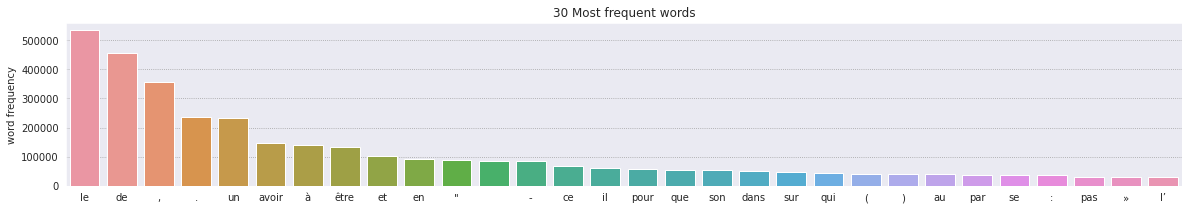

In [ ]:
#@title As expected, top 30 words are stop words. We can clearly see the fast decrease in frequency.

x=list(top_30_dict.keys())
y=list(top_30_dict.values())
plt.figure(figsize=(20, 3))
sns.barplot(x=x,y=y).set(title="30 Most frequent words")
plt.ylabel("word frequency")
plt.show()

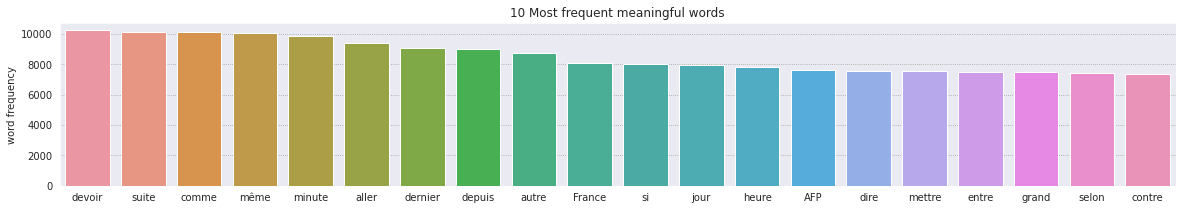

In [ ]:
#@title We can see that the decrease in frequency is way slower than above.
plt.figure(figsize=(20, 3))
x=list(top_meaningful_dict.keys())
y=list(top_meaningful_dict.values())
sns.barplot(x=x,y=y).set(title="10 Most frequent meaningful words")
plt.ylabel("word frequency")
plt.show()

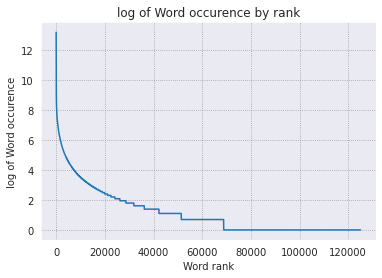

In [ ]:
#@title We plot the logarithm of word frequency by rank of each word to observe the word distribution.
frequency=list(sorted_word_dict.values())
log_frequency=[log(freq) for freq in frequency]
x=range(len(frequency))
sns.lineplot(x=x,y=log_frequency).set(title="log of Word occurence by rank")
plt.ylabel("log of Word occurence")
plt.xlabel("Word rank")
plt.show()

## Descriptive statistics Proust

In [ ]:
import pandas as pd
from transformers import CamembertTokenizer
import re
import string
import seaborn as sns
sns.set_theme()

In [ ]:
df = pd.read_csv('/content/dataset.csv', sep='|', index_col=0).dropna()
df = df[df.label == 1]
corpus = ' '.join(df[df.label == 1].text.to_list())

In [ ]:
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

def cleaning(text):
    text = re.sub("~@~Y", "'", text)
    text = re.sub( "(@\w*\\b\s?|#\w*\\b\s?|&\w*\\b\s?|\n\s?|\\\\|\<|\>|\||\*)", "", text)
    text = re.sub("\/", "", text)
    text = re.sub("l'", "le ", text)
    text = re.sub("d'", "de ", text)
    text = re.sub("j'", "je ", text)
    text = re.sub("qu'", "que ", text)
    text = re.sub("t'", "te ", text)
    text = re.sub("c'", "ce ", text)
    text = text.lower()
    text = text.strip()
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub( ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return (text)

def preprocessing(text):
    text = cleaning(text)
    text = tokenizer.tokenize(text)
    return text

In [ ]:
prepro_corpus = preprocessing(corpus)

In [ ]:
from collections import Counter
counter_words = Counter(prepro_corpus)

In [ ]:
frequency_words = pd.DataFrame.from_dict(dict(counter_words), orient='index', columns=['nb_occurences'])

In [ ]:
frequency_words = frequency_words.sort_values('nb_occurences', ascending=False).reset_index().rename(columns={'index' : 'word'})

In [ ]:
frequency_words

,word,nb_occurences
0,▁de,77644
1,▁que,44048
2,▁le,41274
3,▁la,29599
4,▁à,27645
...,...,...
16891,▁psychiatrie,1
16892,▁transforment,1
16893,dium,1
16894,▁préventif,1


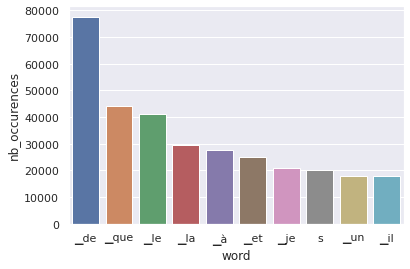

In [ ]:
# Les mots les plus fréquents sont des stopwords, enlevons les pour avoir des résultats plus intéressants
ax = sns.barplot(x=frequency_words.word.head(10), y=frequency_words.nb_occurences.head(10))

In [ ]:
from nltk.corpus import stopwords
stops = stopwords.words('french')
corpus_no_stop = ' '.join([word for word in cleaning(corpus).split(' ') if word not in stops])
corpus_no_stop = tokenizer.tokenize(corpus_no_stop)

In [ ]:
freq_not_stop = pd.DataFrame.from_dict(dict(Counter(corpus_no_stop)), orient='index', columns=['nb_occurences'])
freq_not_stop = freq_not_stop.sort_values('nb_occurences', ascending=False).reset_index().rename(columns={'index' : 'word'})

In [ ]:
freq_not_stop

,word,nb_occurences
0,s,19712
1,▁,14028
2,e,10865
3,▁plus,8859
4,▁comme,7662
...,...,...
16822,▁sioniste,1
16823,▁chaussures,1
16824,adapte,1
16825,▁troupeaux,1


Il reste quelques mots parasites, enlevons les en supprimant les mots de moins de deux lettres

In [ ]:
freq_not_stop = freq_not_stop[freq_not_stop.word.apply(len) > 2]

In [ ]:
freq_not_stop

,word,nb_occurences
3,▁plus,8859
4,▁comme,7662
5,▁si,6786
7,ait,5552
8,▁être,5031
...,...,...
16822,▁sioniste,1
16823,▁chaussures,1
16824,adapte,1
16825,▁troupeaux,1


 Il reste principalement des adverbes et verbes qui sont fréquents mais non considérés comme des stop words, malheureusement ils ne sont pas non plus très significatifs
 Par contre ont commence à observer le style de Proust avec "ait" qui est un des mots les plus courants du corpus

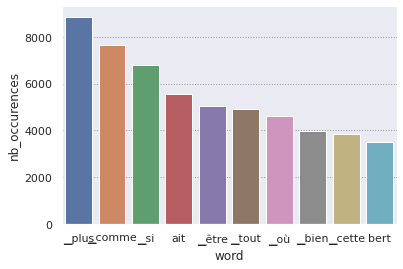

In [ ]:
ax = sns.barplot(x=freq_not_stop.word.head(10), y=freq_not_stop.nb_occurences.head(10))

#Dummy Model

In this part, we build a dummy transfer style model.

In [ ]:
!gdown https://drive.google.com/uc?id=1q4cHZDGJ7SdWUPSl-eYdHCH62bKwuBW5

Downloading...
From: https://drive.google.com/uc?id=1q4cHZDGJ7SdWUPSl-eYdHCH62bKwuBW5
To: /content/dataset.csv
100% 47.2M/47.2M [00:00<00:00, 117MB/s]


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("gilf/french-camembert-postag-model")
model = AutoModelForTokenClassification.from_pretrained("gilf/french-camembert-postag-model")

nlp_token_class = pipeline('ner', model=model, tokenizer=tokenizer, grouped_entities=True)

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/210 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/token_classification.py:136: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  f'`grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="{aggregation_strategy}"` instead.'


In [ ]:
df = pd.read_csv('/content/dataset.csv', sep='|', index_col=0).dropna()

In [ ]:
def cleaning(text):
    text = re.sub("~@~Y", "'", text)
    text = re.sub( "(@\w*\\b\s?|#\w*\\b\s?|&\w*\\b\s?|\n\s?|\\\\|\<|\>|\||\*)", "", text)
    text = re.sub("\/", "", text)
    text = re.sub("l'", "le ", text)
    text = re.sub("d'", "de ", text)
    text = re.sub("j'", "je ", text)
    text = re.sub("qu'", "que ", text)
    text = re.sub("t'", "te ", text)
    text = re.sub("c'", "ce ", text)
    text = text.lower()
    text = text.strip()
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub( ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return (text)

In [ ]:
df['cleaned'] = df.text.apply(cleaning)
df['tokenized'] = df.cleaned.apply(tokenizer.tokenize)

In [ ]:
df_proust = df[df.label == 1]
df_news = df[df.label == 0]

In [ ]:
proust.to_csv('proust.csv', index_label='word')
news.to_csv('news.csv', index_label='word')

In [ ]:
def to_freq_table(dataframe):
    out = pd.DataFrame.from_dict(Counter(dataframe.tokenized.explode().to_list()), orient='index')
    out = out.rename(columns={'index':'token', 0:"freq"}).sort_values('freq', ascending=False)
    return out

In [ ]:
proust = to_freq_table(df_proust)
news = to_freq_table(df_news)

In [ ]:
def get_corres_pos(camembert_pos):
    if camembert_pos == 'NC':
        return wn.NOUN
    if camembert_pos[0] == 'V':
        return wn.VERB
    if camembert_pos[:3] == 'ADJ':
        return wn.ADJ
    if camembert_pos[:3] == 'ADV':
        return wn.ADV
    return None

In [ ]:
sentence = df_news.iloc[10].cleaned
tagged = nlp_token_class(sentence)
new_sentence = []
for word in tagged:
    pos = get_corres_pos(word['entity_group'])
    if pos is None:
        new_sentence.append(word['word'])
    else:
        syns = [synset.lemma_names('fra') for synset in wordnet.synsets(word['word'], lang='fra', pos=pos)]
        if len(syns) == 0:
            new_sentence.append(word['word'])
        else:
            syns = list(set([word for syn in syns for word in syn]))
            syns = {''.join(tokenizer.tokenize(word)): word for word in syns}
            good_tokens = proust.index.intersection([syn for syn in syns.keys()])
            if len(good_tokens) == 0:
                new_sentence.append(word['word'])
            else:
                most_common_syn = proust.loc[good_tokens].iloc[0].name
                new_sentence.append(syns[most_common_syn])
print(sentence)
print(' '.join(new_sentence))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


près de un an après des victimes du novembre retournent au bataclan afp publié le lundi octobre à h novembre le association de victimes des attentats life for paris commémorera avec sobriété le anniversaire de la nuit tragique un rassemblement une table ronde fermée au public un concert de le orchestre des gardiens de la paix le association de victimes des attentats du novembre life for paris commémorera avec sobriété le anniversaire de la nuit tragique où personnes ont trouvé la mort un rassemblement public est prévu à h devant la mairie du xie arrondissement qui avait accueilli de nombreuses victimes dès le soir des attentats à la fin duquel seront lâchés des ballons pour représenter symboliquement dans leur ensemble et leur diversité toutes les victimes a annoncé le association dans un communiqué transmis à le afp une femme intervenue dans la nuit du novembre en tant que personnel soignant jouera au piano et un choeur de gospel interprètera un chant de espoir l après midi qui se dér

#Embedding

We need to embed our data before they can be fed to any model. To do that, we retrieve a word embedding from torchtext.Fastext, and only keep the most frequent words that appear in both the news articles and proust texts

In [ ]:
!wget https://raw.githubusercontent.com/Ellana42/style_transfer_proust/main/datasets/dataset.csv

In [ ]:
df = pd.read_csv('/content/dataset.csv', sep='|', index_col=0).dropna()

In [ ]:
df.head()

,text,label
0,"Les ""grands dangers"" qui guettent les voyageur...",0
1,\nOn prête au premier ministre de l'État d'I...,0
2,L e cortège prend des allures de visite guidée...,0
3,U ne pluie de graines et d’informations s’est ...,0
4,Fiscalité du patrimoine : ce que proposent les...,0


Get dictionnary of word frequencies (non lemmatized)

In [ ]:
frequency_dict=defaultdict(int)
for i in tqdm(range(len(df))):
  text=df.iloc[i]["text"]
  tokens=tokenize_sentence(text,tokenizer)
  for token in tokens:
    frequency_dict[token]+=1

100%|██████████| 20263/20263 [00:13<00:00, 1521.09it/s]


In [ ]:
print("There are",len(frequency_dict),"words in our dataset's vocabulary")

There are 135435 words in our dataset's vocabulary


In [ ]:
#sorted dictionnary by frequency
list_dict=list(frequency_dict.items())
sorted_dict=dict(sorted(list_dict, key = lambda a : a[1],reverse=True))

print(sorted_dict)

{'de': 497327, ',': 480919, '.': 346663, 'le': 331033, 'la': 205857, 'à': 159895, '-': 134400, 'et': 130203, 'les': 125833, 'que': 110308, 'en': 106647, '"': 104854, 'des': 102399, 'un': 98726, 'a': 97464, 'une': 79251, 'du': 76769, 'il': 73032, 'est': 69881, 'pour': 67761, 'dans': 62278, 'ce': 62061, 'qui': 60157, 'sur': 49196, 'au': 47475, 'pas': 47063, ':': 46955, 'par': 45245, '(': 44548, ')': 44539, 'je': 41091, 'plus': 37132, 'ne': 34237, '»': 32779, "n'": 31760, 'son': 31183, 'avec': 30539, "s'": 29774, 'se': 28447, 'elle': 27950, 'mais': 26352, '«': 25133, 'on': 24062, 'y': 22897, 'ont': 22049, 'été': 21399, 'avait': 20762, 'sa': 19926, 'était': 18800, 'nous': 18693, 'cette': 18374, 'comme': 17946, 'aux': 17879, 'sont': 17421, 'vous': 17284, 'ses': 16318, 'ou': 16301, 'être': 15648, 'même': 15182, 'si': 14744, 'après': 14617, 'lui': 14484, 'tout': 14391, '%': 14128, 'fait': 14113, '?': 13805, 'deux': 13532, 'aussi': 12962, 'leur': 12382, 'ces': 11991, '2016': 11545, 'ans': 1141

In [ ]:
#retrieve words that appear more than 10 times in our dataset
filtered_vocab = dict((key, freq) for key, freq in sorted_dict.items() if freq >= 10)

In [ ]:
print("There are",len(filtered_vocab),"words in our pruned dictionnary")

There are 32092 words in our pruned dictionnary


Now retrieve embedding from torch.Fastext

In [ ]:
ft_vectors = FastText(language='fr')
#vocab takes a counter as argument, it keeps the order of the dictionnary and sets the indexes according to these indexes.
#vocab ignores all the words with 0 occurences, since here what we have is an stoi dictionnary and not a counter
#We have to give value at least 1 to the element which was assigned index 0 other wise it won't be included in the vocab object
ft_vectors.stoi=dict((key, value+1) for key, value in ft_vectors.stoi.items())
ft_vectors.stoi
ft_vocab=vocab(ft_vectors.stoi)

.vector_cache/wiki.fr.vec: 3.03GB [01:13, 41.0MB/s]                            
100%|██████████| 1152449/1152449 [02:26<00:00, 7846.84it/s]


In [ ]:
print("There are",ft_vectors.vectors.shape[0],"embedded words in loaded Fasttext pretrained vectors ")

There are 1152449 embedded words in loaded Fasttext pretrained vectors 


Now what we want to do, is to retrieve from Fastext's vectors the embeddings of the most frequent words in our dataset.

In [ ]:
def get_new_embedding(word_dict, min_freq, ft_vectors, ft_vocab,filter):
  '''Creates new embedding vectors and stoi starting from fasttext vectors by
  looking at the most frequent words in word_dict, and keeping from this dict
  the words which are embedded in fasttext model.
  word_dict : vocabulary containing words as keys and they frequencies as values
  min_freq : treshold, words that have a frequency in word_dict of lower than min_freq are not kept
  ft_vectors : tensor from torchtext.Fasttext holding word embeddings
  filter : boolean , if set to True we only keep the words from word_dict that have a freq of min_freq at least,
  otherwise if set to False keep the whole vocabulary of word_dict
  '''
  if filter:
    filtered_word_dict = dict((key, freq) for key, freq in word_dict.items() if freq >= min_freq)
  else:
    filtered_word_dict = word_dict
  matching_vocabs = list(set(filtered_word_dict).intersection(set(ft_vectors.stoi)))

  new_stoi={"</s>" : 1 }
  new_embedding_vect = torch.tensor(ft_vectors["</s>"]).reshape(1,-1)

  for k in tqdm(range(len(matching_vocabs))):
    curr_word = matching_vocabs[k]
    if curr_word != "</s>":
      new_stoi[matching_vocabs[k]]=k+2
      embed_vect = torch.tensor(ft_vectors[curr_word]).reshape(1,-1)
      new_embedding_vect = torch.cat((new_embedding_vect, embed_vect))
  return(new_stoi,new_embedding_vect)

In [ ]:
new_stoi, new_embedding = get_new_embedding(filtered_vocab, 10, ft_vectors, ft_vocab, False)

In [ ]:
print("We have an embedding for a vocabulary of size",new_embedding.shape[0])

We have an embedding for a vocabulary of size 30756


In [ ]:
new_itos=list(new_stoi.keys())

In [ ]:
torch.save(new_embedding,"/content/embedding.pt")

In [ ]:
with open("/content/soit.pickle","wb") as f:
  pickle.dump(new_stoi,f)
with open("/content/itos.pickle","wb") as f:
  pickle.dump(new_itos,f)

# Defining models

Download dataset. This dataset contains both articles sampled previously and proust texts

In [ ]:
!gdown https://drive.google.com/uc?id=1d1WNPOVXIb4yOXiIOTDyOYhhJSkrgtyM

##Dataset class for dataloader

We create a text_dataset class to be able to get data batches, note that this dataset already handles padding and adding $<s>$ and $</s>$ tokens to sentences.

In [ ]:
class text_Dataset(Dataset):
  '''Class to be used to generate a pytorch dataloader of sentences extracted from french articles '''

  def __init__(self, paths, tokenizer_function, vocab_stoi, sequence_size=10, df =None, pad_token="<pad>", start_token="<s>", end_token="</s>",file_type="csv"):
    '''Instantiate french article dataset class
    path_to_articles : list containing path
    tokenizer_function : callable function which tokenizes a string 
    vocab_stoi : stoi indexing
    sequence_size : len of sentence sampled without start of sentence and end of sentence token
    pad_token : padding token default <pad>
    start_token : start of sentence token default <s>
    end_token : end of sentence token default </s>'''

    super().__init__()

    self.paths = paths#list containing list of paths to articles and proust
    self.tokenizer_function = tokenizer_function#tokenizer used
    self.sequence_size = sequence_size
    self.pad_token = pad_token
    self.start_token = start_token
    self.end_token = end_token
    self.stoi=vocab_stoi
    self.file_type=file_type
    self.df=df

    if self.file_type == "json":
      self.len_data = len(self.paths)
    else:
      self.len_data = len(df)
      pass
  def __len__(self):
    '''number of elements in the dataset'''

    return(self.len_data)
  

  def pad(self,token_sequence):
    '''Function to pad sequence
    token_sequence : list of tokens of len < self.sequence_size'''

    pad_size = self.sequence_size-len(token_sequence)
    result = [self.start_token] + token_sequence + [self.pad_token for i in range(pad_size)] + [self.end_token]
    
    return result
  

  def sample(self,tokens):
    ''' sample sequence from token sequence
    tokens : list of tokens'''

    nb_tokens=len(tokens)
    starting_index=np.random.randint(nb_tokens)

    
    if starting_index + self.sequence_size < nb_tokens :
      result = [self.start_token] + tokens[starting_index : starting_index + self.sequence_size] + [self.end_token]
    
    else:
      result= tokens[starting_index : nb_tokens]
      result=self.pad(result)
    
    return result


    pass

  def __getitem__(self, idx):
    '''get a sentence of size sequence_size from file of index idx
    '''

    if self.file_type=="json":
      text_file=read_json(self.paths[idx])

      label=text_file["label"]
      text=text_file["text"]

      tokens=self.tokenizer_function(text)
      
      sequence=[self.stoi[token] for token in self.sample(tokens)]
    
    else:

      label=(self.df).iloc[idx]["label"]
      text=(self.df).iloc[idx]["text"]

      tokens=self.tokenizer_function(text)
      sequence=[self.stoi[token] for token in self.sample(tokens)]

    return(torch.LongTensor(sequence),label)




In [ ]:
tokenizer_function=functools.partial(tokenize_sentence,tokenizer=tokenizer)
articles_dataset=text_Dataset(glob.glob("/content/data/french_news_articles/*.json"),tokenizer_function=tokenizer_function, vocab_stoi=ft_vocab, file_type="json")

for i in range(5):
  print(articles_dataset[np.random.randint(len(articles_dataset))])

([1152450, 2, 6, 279, 2, 233, 52009, 8, 328, 3918, 4687, 0], 0)
([1152450, 59, 863, 6, 1903, 4, 7, 401, 2, 253, 4577, 0], 0)
([1152450, 35, 58224, 9, 7, 13660, 4, 52, 122, 36, 1152449, 0], 0)
([1152450, 822, 2, 6846, 826, 1, 67642, 576, 5, 32059, 192, 0], 0)
([1152450, 1627, 2, 1110, 36718, 7, 2507, 2, 3988, 1152449, 112592, 0], 0)


##Style transfer model

Since we are using non parallel corpora, meaning that for a sentence of a given style we do not have the equivalent sentence in the other style, we train a style conditionnal autoencoder. We use a model proposed by the paper [Style Transfer from Non-Parallel Text by Cross-Alignment](https://arxiv.org/abs/1705.09655) as basis.

The main idea behind the paper is to create a style conditional auto-encoder. This auto encoder should be so that the style latent representation should be independent from the content latent representation. To do that, they propose 2 different models, **Aligned auto encoder** and **cross aligned auto encoder** which make use of discriminators. 


Since adding discriminators makes training (and defining model) more tedious, we decided to work with a simpler model.

In this model, style labels are embedded thanks to a linear layer to a style representative vector of dimension style_embed_dim.

The hidden states of both the encoder and the decoder are of size hidden_dim = style_embed_dim + content_embed_dim.

content_embed_dim is the dimension of the embedding of the text's content.

The encoder is given as initial state a vector which is the concatenation of the style embedding vector and a zero vector (of dimension content_embed_dim). From its final hidden state, we retrieve the embedding of the text's content (if last_hidden is the final hidden state of the encoder, we simply set content_embed_dim = last_hidden[style_embed_dim:]).

After that, the initial hidden state of the decoder is chosen as the concatenation of the style embedding vector and the content embedding vector.

We finally map the final hidden state of the decoder using a linear layer to a vector of dimension the size of the vocabulary, and we use this vector to predict the next output token.


For the embedding, additionnaly to the smaller size vocabulary embedding defined before, we add a padding embedding defined as a zero vector, and a trainable embedding layers of size 2 ( 2 embedded words) to learn the embedding of the tokens $<s>$ (beginning of sentence) and $<unk>$ (unknown) which are not present int fasttext embedded vectors and thefore are not present in our smaller size vocabulary embedding vectors.

For all the defined classes, the parameters are retrieved from a dictionnary of parameters

###Define an rnn class which will form the basis class for both the encoder and the decoder

In the mentionned paper, the authors use rnn with a single gru as basis for encoders and decoders. We decided to do the same.

 We define below an rnn class to be used to created both the encoders and decoders.

Again, that Since in our models we do not have an embedding for special tokens $<s>$ and $ <unk>$, we define a trainable embedding layer of size 2 (corresponding to the size of [$<s>,<unk>$]) which will be used to embed these 2 tokens.

In [ ]:
class rnn(nn.Module):
  '''simple single gru cell rnn class'''

  def __init__(self, param_dicts,  pretrained_embedding = None ):
    '''Instantiates rnn encoder class
    param_dicts : dictionnary of parameter
    pretrained_embedding : vectors embedding with __getitem__ method
    batch_size : batch size
    '''
    
    super().__init__()

    try:
      self.nb_layers = param_dicts["nb_layers"]
    except:
      self.nb_layers = 1
    
    try:
      self.embed_size = param_dicts["embed_size"]
    except:
      self.embed_size = 300
    
    try:
      self.hidden_dim = param_dicts["hidden_dim"]
    except:
      self.hidden_dim = 256
    
    #instantiates gru function with imput of dimension embed_size and hidden state of the same dimension
    self.gru=nn.GRU(self.embed_size, self.hidden_dim, num_layers = self.nb_layers, batch_first = True)
  
  
  def forward(self, x, initial_state ):

    '''forward function
    x : batch of sequences
    state : previous hidden state'''
    
    previous_states,final_state = self.gru(x,initial_state)

    return previous_states, final_state

###Style transfer model

simple style transfer model as described above

In [ ]:
class style_transfer(nn.Module):
  '''Style transfer class.  '''
  def __init__(self, parameters_dicts, pretrained_embedding):
    '''parameters_dict : dictionnary containing parameters 
    batch_size : batch size'''
    super().__init__()

    #First of all retrieve general parameters from parameter dictionnary
    #label smoothing parameter
    try:
      self.label_smoothing_sigma = parameters_dicts["style"]["label_smoothing_sigma"]
    except:
      self.label_smoothing_sigma = 0.1
    #learning rate
    try :
      self.lr = parameters_dicts["style"]["lr"]
    except:
      self.lr = 0.001
    # Style embedding dimension
    try :
      self.style_embed_dim = parameters_dicts["style"]["style_embed_dim"]
    except :
      self.style_embed_dim = 128
    #Max sequence length when generating sequence with forward
    try:
      self.max_generated_sequence_len = parameters_dicts["style"]["max_generated_sequence_len"]
    except:
      self.max_generated_sequence_len = 15
    #end of sentence index
    try:
      self.eos_idx = parameters_dicts["style"]["eos_idx"]
    except:
      self.eos_idx = 0
    #start of sentence index
    try:
      self.sos_idx = parameters_dicts["style"]["sos_idx"]
    except:
      self.sos_idx = 30758#1152451
    #size of the vocabulary
    try:
      self.vocab_size = parameters_dicts["style"]["vocab_size"]
    except:
      self.vocab_size = pretrained_embedding.shape[0]
    # word embedding size
    try :
      self.embed_size = parameters_dicts["style"]["embed_size"]
    except :
      self.embed_size = 10
    # number of additionnal tokens
    try :
      self.additionnal_tokens = parameters_dicts["style"]["additionnal_tokens"]
    except :
      self.additionnal_tokens = 3 #pad, sos, unk
    #dropout probability
    try :
      self.dropout_p = parameters_dicts["style"]["dropout_p"]
    except:
      self.dropout_p = 0.3
    #batch size
    try :
      self.batch_size = parameters_dicts["style"]["batch_size"]
    except:
      self.batch_size = 1


    #Parameter of gumbel softmax
    self.tau = 1.0
    # For eval to eval on batches of size != batch size
    self.size = self.batch_size
    ##########################################################################################################
    # Autoencoder
    ##########################################################################################################
    
    #Define encoder
    try:
      encoder_dict = parameters_dicts["autoencoder"]["encoder"]
    except:
      encoder_dict = None
    encoder = rnn(encoder_dict)

    self.hidden_dim = encoder.hidden_dim

    #Define decoder
    try:
      decoder_dict = parameters_dicts["autoencoder"]["decoder"]
    except:
      decoder_dict = None
    
    decoder = rnn(decoder_dict)
    
    #Define linear network used to get a vector of the size of the vocabulary from result of decoder
    self.convert_to_vocab = nn.Linear(self.hidden_dim, self.vocab_size + self.additionnal_tokens)


    #Autoencoder
    self.autoencoder={"encoder" : encoder, "decoder" : decoder}

    self.dropout_layer=nn.Dropout(self.dropout_p)

    self.encoder_initial_state = None
    self.decoder_initial_state = None
    ##########################################################################################################
    # Layers used to embed text idx tokens
    ##########################################################################################################
    

    #Below : in pretrained_embed we create an Embedding layer from the pretrained embedding vectors given as argument,
    #We also add an embedding vector full of 0s which will be associated to padding token
    embedding_vectors=torch.cat( (pretrained_embedding, torch.zeros(size=(1,self.embed_size))))
    self.pretrained_embed=nn.Embedding.from_pretrained(embedding_vectors, freeze=True, padding_idx = self.vocab_size)

    #Below : in learnable_embedding we create an Embedding layer consisting of 2 trainable vectors.
    #First vector will be embedding of <unk> token and second will be embedding of <s> token
    self.learnable_embed=nn.Embedding.from_pretrained( torch.randn(size=(2,self.embed_size)), freeze=False )

    ##########################################################################################################
    # Layers used to embed style
    ##########################################################################################################

    #Simple linear model to embed style (0 or 1 labels) into vector of defined style size
    self.encoder_label_embedder = nn.Linear(1, self.style_embed_dim)
    self.decoder_label_embedder = nn.Linear(1, self.style_embed_dim)

    ################################################
    #Loss / optimizer
    #################################

    self.reconstruction_loss = nn.CrossEntropyLoss()

    self.autoencoder_optim = torch.optim.Adam([{"params" : self.learnable_embed.parameters()},
            {'params': (self.autoencoder)["encoder"].parameters()},
            {'params': (self.autoencoder)["decoder"].parameters()},
             {'params': self.encoder_label_embedder.parameters()},
             {'params': self.decoder_label_embedder.parameters()},
             {'params': self.convert_to_vocab.parameters()}],
            lr=self.lr)

    return None #end of __init__
  
  #######################################################################################################################################

  #############################################
  #
  #############################################
  def get_final_hiddens(self,lengths,hiddens):
    '''We can hope to predict an eos token. In this case, we want to retrieve the hidden state right after the eos was predicted (and not the later ones)
    lengths : int tensor which contains the position in which the eos token has been predicted in our generated sentences
    hiddens : list of final hidden layer. Shape (batch_size,max_seq_length,hidden_dim), hiddens[i,j] is the hidden state obtained
    after predicting the jth token of the ith batch using the previous j-1 tokens'''

    final_hiddens = torch.zeros((self.size,1, self.hidden_size))
    for i in range(self.size):
      final_hiddens[i,:,:] = hiddens[i,lengths[i],:]
    return final_hiddens

  
  #############################################
  #embbeding from token indexes function
  #############################################
  def embed(self,x):
    '''Embedding of input using the 2 embedding layers defined above
    x : batch input or text indexes of dim 2 (batch_size,sequence_size) ex [[0,1,2],[3,4,5]] '''
    
    embedding_mask = x> self.vocab_size #mask : tensor of boolean, True means that index belongs to either <unk> or to <s> (not in pretrained vectors)

    pretrained_x = x.clone() #In this vector, we will store embedding of the tokens which are not <unk> or <s>
    
    #Set indexes of <unk> and <s> to the index of padding index, embedding of these vectors is zero tensor
    pretrained_x[embedding_mask] = self.vocab_size

    #Now embed this vector using pretrained embedding vectors
    embedded_x = self.pretrained_embed(pretrained_x)
    embedded_x[embedding_mask] = self.learnable_embed(x[embedding_mask]-self.vocab_size-1)

    return embedded_x

  #############################################
  # Label smoothing function
  #############################################
  def label_smoothing(self,labels) :
    ''' return a smooth (noisy) version of the labels 
    labels : batch tensor of labels (0 or 1) dim 3 (batch_size,1,1)'''
    
    mask = (labels == 1)#Label 1
    labels=torch.tensor(labels).float()

    noise=torch.rand(mask.sum())
    labels[mask] -= self.label_smoothing_sigma * noise#remove noise to labels 1
    
    noise=torch.rand((~mask).sum())
    labels[~mask] += self.label_smoothing_sigma *noise#add noise to labels 0

    return labels
  
  #############################################
  # Use Gumbel trick to get embedding
  #############################################

  def gumbel_word_sample(self, embeddings, output):
    '''Uses gumbel softmax to differentiably sample hot encoded vector and return average embedding using softmax.
    embeddings : embedding vectors
    output : last hidden state of the decoder (embeddings of size hidden_dim)  '''

    if self.training:
      drop = nn.Dropout(p=0.2)
      output=drop(output)
      
    vocab_embedd = self.convert_to_vocab(output)#embed to vocabulary size
    gumbel_softmax_output=F.gumbel_softmax(vocab_embedd, tau = self.tau)#apply gumber softmax

    token_approx = torch.matmul(gumbel_softmax_output,embeddings)#average embeddings by softmax probability to get new embedding

    return token_approx, gumbel_softmax_output
  
  #############################################
  # Create initial states from both the encoder and the generator
  #############################################
  def initial_state_embedder(self, input, labels, same_labels = True, obj_labels = None):
    '''Create initial hidden state for rnn training. Encoder's state is stored under  self.encoder_initial_state and decoder's state under 
    self.decoder_initial_state. returns None
    input : inputs of the encoder (batch_size,seq_len, embed_dim)
    labels : style labels 3 (batch_size,1,1)
    same_labels : use same labels / styles for encoder and decoder
    obj_labels : if same_labels is set to False, use obj_labels embedding as input to the decoder
    '''
    
    #First smooth the labels
    smooth_labels=self.label_smoothing(labels.float())
    #Get encoder style embedding
    encoder_style_embed = self.encoder_label_embedder(smooth_labels)
    #Create encoder's initial state
    self.encoder_initial_state = torch.cat((encoder_style_embed , torch.zeros(size=(self.size, 1, self.hidden_dim - self.style_embed_dim)) ), 2)
    self.encoder_initial_state = self.encoder_initial_state.view(1,self.size,self.hidden_dim)

    ###################################################
    #Now we want the decoder's initial state. To do that, since the decoder is content dependent, we need to retrieve the content
    #embedding from the output of the encoder
    
    # First if we want the outputs to have the same style as the input
    if same_labels:
      
      _, encoder_final_state = self.autoencoder["encoder"](input,self.encoder_initial_state)
      content = encoder_final_state[:,:,self.style_embed_dim:] #retrive from hidden states embeddings of sizes content_dim representing the content

      #Now, using this content and the encoder's inputs, we will create the decoder's input
      decoder_style_embed = self.decoder_label_embedder(smooth_labels)
      self.decoder_initial_state = torch.cat( (decoder_style_embed.view(1,self.size,-1), content.view(1,self.size,-1)) , 2)
    
    # Now if we want the outputs to have the styles encoded in other_labels
    else:

      smooth_obj_labels = self.label_smoothing(obj_labels.float())
      _, encoder_final_state = self.autoencoder["encoder"](input,self.encoder_initial_state)
      content = encoder_final_state[:,:,self.style_embed_dim:] #retrive from hidden states embeddings of sizes content_dim representing the content

      decoder_style_embed = self.decoder_label_embedder(smooth_obj_labels)
      self.decoder_initial_state = torch.cat( (decoder_style_embed.view(1,self.size,-1), content.view(1,self.size,-1)) , 2)
    
    return None

  #############################################
  # get encoder's outputs
  #############################################
  def run_encoder(self, x):
    ''' get output and last hidden state of embedding x, creating the initial states using the smooth labels and passing them to encoder
    x : embedded_input
    initial_state : self.encoder_initial_state'''

    
    state = self.encoder_initial_state
    output,result=self.autoencoder["encoder"](x,state)

    return(output,result)
  
  #############################################
  # autoencode data
  #############################################
  def generate_tokens(self, embedded_tokens):
      '''given a list of embedded_tokens, return all the outputs of the decoder embedded into vocab size using convert_to_vocab and raw
      embedded_tokens : current tokens generated'''

      initial_state = self.decoder_initial_state
      output, hidden_state = self.autoencoder["decoder"](embedded_tokens, initial_state)


      if self.training:
        output = self.dropout_layer(output)

      to_vocab_ = self.convert_to_vocab(output)
      return to_vocab_, output

  #############################################
  # get batch reconstruction loss
  #############################################
  def batch_loss(self, gen_input, targets_tokens, labels, eval_size=None  ):
    '''compute loss over a batch
    gen_input : output of encoder
    targets_tokens : indexes
    labels : style labels
    '''

    if self.training:
      self.size = self.batch_size
    else:
      self.size = eval_size
    
    reconstruction_loss =0
    f_labels = labels

    self.initial_state_embedder(gen_input, labels, True)
    vocab_output, _ = self.generate_tokens(gen_input)

    loss = self.reconstruction_loss(vocab_output.view(-1,self.vocab_size + self.additionnal_tokens),targets_tokens.view(-1))

    return(loss)
  
  #############################################
  # train model on batch
  #############################################
  def train_batch(self, input_idx_tokens, labels, cur_iter, iter_verbose = 100):
    '''train model en batch
    input_idx_tokens : input of token vocab indexes
    labels : style labels
    cur_iter : current_iteration'''
    self.train()#train mode
    self.autoencoder_optim.zero_grad()#zero gradient
    gen_input=self.embed(input_idx_tokens)#embed input indexes
    labels = labels.float()

    loss = self.batch_loss(gen_input, torch.tensor(input_idx_tokens), labels)

    if cur_iter % iter_verbose == 0 :
      print("reconstruction loss is", loss.item())

    loss.backward()
    self.autoencoder_optim.step()
    return None
  
  #############################################
  # eval model on batch
  #############################################
  def eval_batch(self, input_idx_tokens, labels):
    self.eval()
    gen_input=self.embed(input_idx_tokens)
    labels = labels

    loss = self.batch_loss(gen_input, input_idx_tokens, labels, len(input_idx_tokens))
    return loss
  
  #############################################
  # generate sequence
  #############################################
  def hiddens_tokens_embed_generation(self):
    '''returns list of last hiddens states and tokens given by model for every step (step : 1 generate token from <bos> , step 2
    generate from <bos> and generated output ...
    '''

    
    #get all embeddings : pretrained + trainable ones
    embeddings=torch.cat((self.pretrained_embed.parameters().__next__(), self.learnable_embed.parameters().__next__())).clone()
    #initial state
    state=self.decoder_initial_state
    
    hiddens = torch.zeros(self.size, self.max_generated_sequence_len, self.hidden_dim)
    tokens = torch.zeros(self.size, self.max_generated_sequence_len, self.embed_size)

    sentence=(torch.tensor([[self.sos_idx]])).repeat((self.size,1))
    #predicted_indexes=torch.tensor([self.sos_idx]).repeat((self.batch_size,1,1))

    lengths=torch.tensor([self.max_generated_sequence_len for k in range(self.size)])

    for i in range(self.max_generated_sequence_len):

      sentence_embedding=self.embed(sentence)
      _,state = (self.autoencoder)["decoder"](sentence_embedding,state)
      #to_vocab = self.convert_to_vocab(state)
      token_approx, gumbel_softmax_output = self.gumbel_word_sample(embeddings , state)
      gumbel_softmax_output = gumbel_softmax_output.view(self.size,self.vocab_size+self.additionnal_tokens)
      predicted_indexes = torch.argmax(gumbel_softmax_output.squeeze(1),1)
      predicted_eos_mask = predicted_indexes == self.eos_idx

      lengths[predicted_eos_mask] = i #set index of eos token (current length + 1 for eos token)

      sentence = torch.cat((sentence, predicted_indexes.view(self.size,1)),1)

      hiddens[:,i,:] = state
      tokens[:,i,:] = token_approx

    return hiddens , tokens, lengths, sentence
  
  #############################################
  # forward function, to be called only to predict a sequence of opposite style from input
  #############################################
  def predict(self,input_idx_tokens, input_labels, obj_labels):
    '''return predicted index sequence
    input_idx_tokens : input index tokens sequence
    labels : style labels'''
    #eval mode
    self.eval()
    #get sequences length
    self.size = len(input_idx_tokens)
    #embed tokens
    gen_input=self.embed(input_idx_tokens)
    #Now create initial hidden state for the encoder using the real input labels
    #And for the decoder using the objective labels
    self.initial_state_embedder(gen_input,input_labels, False, obj_labels)
    #We generate the predicted sentences. The function takes no argument as
    # the output of the encoder was taken into account when
    #generating the initial state of the decoder
    _,_,_,predicted_sentences = self.hiddens_tokens_embed_generation()

    return(predicted_sentences)

#Test that model works with real data

Below, we retrieve the previously defined smaller size embedding vector, stoi and itos from google drive 

##Load small size embedding vectors, stoi and itos 

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/11S9pXozrl3odmTNqpXGL8qQonIH1jYhC?usp=sharing

Retrieving folder list
Processing file 1RshSrc75VhX-5p0cQwDKO_lrIVR7AKbr embedding.pt
Processing file 1OBb9ZDGwPuZv3crnBYFNYkpbfLHeZGZp itos.pickle
Processing file 1NPqaoWQ7cdEnedc-ZIXA67czLVy0WgpO stoi.pickle
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1RshSrc75VhX-5p0cQwDKO_lrIVR7AKbr
To: /content/embedding/embedding.pt
100% 36.9M/36.9M [00:00<00:00, 70.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OBb9ZDGwPuZv3crnBYFNYkpbfLHeZGZp
To: /content/embedding/itos.pickle
100% 551k/551k [00:00<00:00, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NPqaoWQ7cdEnedc-ZIXA67czLVy0WgpO
To: /content/embedding/stoi.pickle
100% 643k/643k [00:00<00:00, 122MB/s]
Download completed


In [ ]:
pretrained_vectors = torch.load("/content/embedding/embedding.pt")

with open("/content/embedding/stoi.pickle","rb") as f:
  stoi = pickle.load(f)

with open("/content/embedding/itos.pickle","rb") as f:
  itos = pickle.load(f)

In [ ]:
pretrained_vectors.shape #Embedding of 30756 words, embedding dimension is 300

torch.Size([30756, 300])

In [ ]:
print(stoi)

{'</s>': 1, 'confidentielles': 2, 'festivals': 3, 'dfco': 4, 'épargner': 5, 'paraphé': 6, 'capable': 7, 'dalia': 8, 'permise': 9, 'actes': 10, 'emblée': 11, 'enquêter': 12, 'entrés': 13, 'chasseur': 14, 'fortuné': 15, 'gaussin': 16, 'shebab': 17, 'trente': 18, 'épuiser': 19, 'joyeuse': 20, 'rauque': 21, 'tribunaux': 22, 'cibles': 23, 'acceptées': 24, 'rosneft': 25, 'sentinelle': 26, 'orgues': 27, 'gagnés': 28, 'bille': 29, 'propose': 30, 'rein': 31, 'telle': 32, 'régler': 33, 'belgique': 34, 'bastide': 35, 'clés': 36, 'matthew': 37, 'vanité': 38, 'pardonnez': 39, 'oeil': 40, 'green': 41, 'sauvait': 42, 'turquie': 43, 'boeuf': 44, 'poteaux': 45, 'météo': 46, 'agenouiller': 47, 'signalé': 48, 'incessants': 49, 'tiendront': 50, 'poussé': 51, 'agi': 52, 'omanais': 53, 'impuissance': 54, 'maya': 55, 'mollement': 56, 'décision': 57, 'olympiens': 58, 'tunnel': 59, 'opté': 60, 'intégralement': 61, 'handicapé': 62, 'vercoutre': 63, 'glas': 64, 'soprano': 65, 'partager': 66, 'défiscaliser': 67, 

In [ ]:
print(itos)

['</s>', 'confidentielles', 'festivals', 'dfco', 'épargner', 'paraphé', 'capable', 'dalia', 'permise', 'actes', 'emblée', 'enquêter', 'entrés', 'chasseur', 'fortuné', 'gaussin', 'shebab', 'trente', 'épuiser', 'joyeuse', 'rauque', 'tribunaux', 'cibles', 'acceptées', 'rosneft', 'sentinelle', 'orgues', 'gagnés', 'bille', 'propose', 'rein', 'telle', 'régler', 'belgique', 'bastide', 'clés', 'matthew', 'vanité', 'pardonnez', 'oeil', 'green', 'sauvait', 'turquie', 'boeuf', 'poteaux', 'météo', 'agenouiller', 'signalé', 'incessants', 'tiendront', 'poussé', 'agi', 'omanais', 'impuissance', 'maya', 'mollement', 'décision', 'olympiens', 'tunnel', 'opté', 'intégralement', 'handicapé', 'vercoutre', 'glas', 'soprano', 'partager', 'défiscaliser', 'montrent', 'livrera', 'taclé', 'opus', 'lors', 'réservée', 'ressorti', 'refusa', 'joie', 'contemporain', 'figurait', 'infléchir', 'conditionne', 'margrethe', 'interrogés', 'assassins', 'homosexuelles', 'gas', 'darfour', 'superviser', 'filoche', 'geographic',

##Define vocabulary

In [ ]:
ft_vocab=vocab(stoi)
print("index of </s> token is",ft_vocab["</s>"])
#Now add special tokens at the end of the vocab to avoid embedding issues later on
#since inserting them in the middle of the stoi vocab will shift all other indexes, which would mess us the embedding
#when using nn.embedding later on
index_pad=len(ft_vocab)#padding
index_unk=len(ft_vocab)+1#unknown 
index_sos=len(ft_vocab)+2#start of sentence


ft_vocab.insert_token("<pad>",index_pad)
ft_vocab.insert_token("<unk>",index_unk)
ft_vocab.insert_token("<s>",index_sos)

ft_vocab.set_default_index(index_unk)

index of </s> token is 0


In [ ]:
print("index of unknown is",index_unk)

index of unknown is 30757


## dataset

If not downloaded before, get csv dataset

In [ ]:
!wget https://raw.githubusercontent.com/Ellana42/style_transfer_proust/main/datasets/dataset.csv
df = pd.read_csv('/content/dataset.csv', sep='|', index_col=0).dropna()

--2022-04-24 11:04:45--  https://raw.githubusercontent.com/Ellana42/style_transfer_proust/main/datasets/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47153844 (45M) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>]  44.97M   107MB/s    in 0.4s    

2022-04-24 11:04:46 (107 MB/s) - ‘dataset.csv’ saved [47153844/47153844]



In [ ]:
tokenizer_function=functools.partial(tokenize_sentence,tokenizer=tokenizer)
df = pd.read_csv('/content/dataset.csv', sep='|', index_col=0).dropna()

In [ ]:
dataset = text_Dataset("", tokenizer_function, ft_vocab, df=df)
dataset[0]

(tensor([30758, 30757, 28618, 26942, 28536, 27185, 11383, 16670,  7443, 16665,
          9252,     0]), 0)

In [ ]:
train_ratio, val_ratio, test_ratio = (0.8, 0.1, 0.1)
train_size = int(len(dataset) * train_ratio)
val_size = int(len(dataset) * val_ratio)
test_size = len(dataset) - train_size - val_size
train, val, test = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
batch_size = 64
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle = True)
val_dataloader = DataLoader(val, batch_size=batch_size, shuffle = True)

In [ ]:
#input_idx = None
#labels = None
#for x,y in test_dataloader:
  #input_idx,labels = x,(y.view(-1,1,1))
  #break

In [ ]:
#input_idx.shape

torch.Size([64, 12])

## Training

In [ ]:
def train(epochs=4, evaluation=False):
    print("Start training...\n")
    batch_counts = 0
    for epoch_i in range(epochs):
        t0_epoch, t0_batch = time.time(), time.time()
        step, total_loss, batch_loss, batch_count = 0, 0, 0, 0
        for _ in range(len(train_dataloader)):
            try:
                input_idx, labels = next(iter(train_dataloader))
            except ValueError:
                continue
            labels = labels.view(-1,1,1)
            batch_count += 1
            step += 1
            loss = style_model.train_batch(input_idx, labels, 0)
            batch_loss += loss
            total_loss += loss
        t0_epoch, t0_batch = time.time(), time.time()
        if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
            time_elapsed = time.time() - t0_batch
            print(
            f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}"
            )
            print("-" * 70)
            print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
            batch_loss, batch_count = 0, 0
            t0_batch = time.time()
        avg_train_loss = total_loss / len(train_dataloader)
        print("-" * 70)
        if (evaluation==True):
            total_loss = 0
            n_batch = 0
            for _ in range(len(val_dataloader)):
                try:
                    input_idx, labels = next(iter(val_dataloader))
                except ValueError:
                    continue
                labels = labels.view(-1,1,1)
                n_batch += 1
                total_loss += style_model.eval_batch(input_idx, labels)
                time_elapsed = time.time() - t0_epoch
            val_loss = total_loss/len(val_dataloader)
            print(
                f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {'-':^9} | {time_elapsed:^9.2f}"
            )
            print("-" * 70)
            print("\n")
            print("Training complete!")
            return (0)

Décommenter pour réentrainer le style_modèle :

In [ ]:
#train(evaluation=True)

## retrieve model from weights

In [ ]:
parameters_dict = {}

batch_size=64
style_embed_dim = 128 # dim of the Latent representation of the style variable
max_generated_sequence_len = 15
vocab_size = len(ft_vocab)-3 # since pretrained vectors do not have embedding for <s> <pad> and <unk> which are in vocabulary
hidden_dim=258
embed_size = 300
lr = 0.01

style_dict={"batch_size" :batch_size,"label_smoothing_sigma" : 0.1, "lr": lr, "style_embed_dim" : style_embed_dim, "max_generated_sequence_len":max_generated_sequence_len, "eos_idx":0, "vocab_size":vocab_size, "embed_size":embed_size, "sos_idx":index_sos}

encoder_dict={"nb_layers":1, "embed_size":embed_size,"hidden_dim":hidden_dim}
decoder_dict={"nb_layers":1, "embed_size":embed_size,"hidden_dim":hidden_dim}

autoencoder_dict={"encoder":encoder_dict,"decoder":decoder_dict}

parameters_dict["style"]=style_dict
parameters_dict["autoencoder"]=autoencoder_dict


In [ ]:
parameters_dict

{'autoencoder': {'decoder': {'embed_size': 300,
   'hidden_dim': 258,
   'nb_layers': 1},
  'encoder': {'embed_size': 300, 'hidden_dim': 258, 'nb_layers': 1}},
 'style': {'batch_size': 64,
  'embed_size': 300,
  'eos_idx': 0,
  'label_smoothing_sigma': 0.1,
  'lr': 0.01,
  'max_generated_sequence_len': 15,
  'sos_idx': 30758,
  'style_embed_dim': 128,
  'vocab_size': 30756}}

Now get model saved weights

In [ ]:
!gdown https://drive.google.com/uc?id=1rk49gjzrvCP5BLGldFqAFO2W3ZFxx5KI

Downloading...
From: https://drive.google.com/uc?id=1rk49gjzrvCP5BLGldFqAFO2W3ZFxx5KI
To: /content/style_model
100% 68.8M/68.8M [00:01<00:00, 41.7MB/s]


In [ ]:
style_model = style_transfer(parameters_dict,pretrained_vectors)


In [ ]:
style_model.load_state_dict(torch.load("/content/style_model"))

<All keys matched successfully>

do not pay attention to 2 first lines, they are just printing artefacts (removed now from model)

In [ ]:
predictions = style_model.predict(input_idx,labels,1-labels)
predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[30758,  8322, 29423,  ..., 21595, 18552,  3443],
        [30758,  3276, 18839,  ..., 22705, 12301, 30641],
        [30758,  7447,  7597,  ...,  6260,  2300, 26195],
        ...,
        [30758, 24612, 17781,  ...,  1630, 25529, 16050],
        [30758, 12491,  9662,  ...,  4569,  4310, 10491],
        [30758,  3276, 24120,  ..., 11718,  8367, 26426]])

In [ ]:
#training can be done using train_batch function
#style_model.train_batch(input_idx, labels, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:330: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


reconstruction loss is 9.852322578430176


##Get sentences from indexes

In [ ]:
def retrieve_sentence(indexes,itos, idx_end):
  '''returns sentences from tokens
  indexes : 2 dim tensor (batch size, nb tokens)'''
  sentences = []
  extended_itox = itos + ["<pad>","<unk>","<s>"]
  for list_indexes in indexes:
    sentence=[]
    for index in list_indexes :

      if index == idx_end:
        
        break
      
      else:

        sentence.append(extended_itox[index])
    sentence = " ".join(sentence)
    sentences.append(sentence)
  return sentences

In [ ]:
import pprint

In [ ]:
predicted_sentences = retrieve_sentence(predictions,itos,0)
pprint.pprint(predicted_sentences)

['<s> rafraîchir douceur mousse silences éterniser charline marquantes mérite '
 'reims escrocs montage préjugés exposés œillets assurément',
 '<s> sentis liés ajustement certaines oubliant calaisis divulguées terribles '
 'eyraud hulot pare but secouristes columbus suffrages',
 '<s> sentir déchaîne climatiques formateurs marcourt fin sentir mérimée '
 'sharapova varié montana âme tlmep convaincu accroître',
 '<s> palerme grade collecteurs paresseusement yemen proverbe cessez '
 'fonctionnaires renaît maradona santé desmond déchaîne fortuites servie',
 '<s> metz fp pologne véronique miliciens donation impalpable por processus '
 'historique chopra couleuvre faiblit duval agissait',
 '<s> admission proie loti cruelle dijonnais infirmer préfet détaillé jolie '
 'malles officiellement distinctes enclavé éducateurs réponses',
 '<s> gravures provision éloignée conseillère appartement alignement '
 'antipathie plafonner alimentation illustrée apparente biographie '
 'francophones éjecté patr

# style transfer long sentences

In [ ]:
tokenizer_function=functools.partial(tokenize_sentence,tokenizer=tokenizer)

In [ ]:
def get_sentences_tokenized_to_good_size(sentences, tokenizer_function, nb_tokens, pad_token="<pad>"):
  '''transform text sentences into list of tokens of same len
  sentences : list of str sentences'''
    
  splits = []
  len_tokenized_sentences=[]

  for sentence in sentences :
    tokens = tokenizer_function(sentence)
      
    if len(tokens) < nb_tokens:

      tokens = tokens + [pad_token for i in range(nb_tokens-len(tokens))]
      
    else:
      tokens = tokens [:nb_tokens]

    splits.append(tokens)
    
  return splits

def split_into_batches_of_idx( split, nb_tokens, batch_size, vocab, start_token="<s>", end_token="</s>", sequence_size=10):
  '''split result of get_sentences_tokenized_to_good_size into batches'''

  nb_batches = nb_tokens // sequence_size
  batches = []
    
  for i in range(nb_batches) :
      
    result =  []

    for k in range(batch_size) :

      token_sentence = split[k]
      sequence = token_sentence[i*sequence_size : (i+1)*sequence_size ]
      result.append([vocab[start_token]] + [vocab[word] for word in sequence] + [vocab[end_token]])
      
    batches.append(result)
    
  return batches

def get_list_of_batches_from_sentences(sentences, tokenizer_function, nb_tokens, vocab, batch_size=64, sequence_size=10):
  '''takes a list of sentences as argument and returns list of batches if size index'''
  split = get_sentences_tokenized_to_good_size(sentences, tokenizer_function, nb_tokens)
  res = split_into_batches_of_idx( split, nb_tokens, batch_size, vocab)
  return(res)

In [ ]:
def style_transfer_sentences(sentences, tokenizer_function, nb_tokens, vocab, model, labels, itos, idx_end = 0):
  
  labels = torch.tensor(labels).view(-1,1,1)
  batches = get_list_of_batches_from_sentences(sentences, tokenizer_function, nb_tokens, vocab)
  res_sentences = ["" for i in range(64)]
  for batch in batches:
    predictions = model.predict(torch.tensor(batch), labels, 1-labels)
    text_sentences = retrieve_sentence(predictions, itos, idx_end)

    for i in range(64):
      res_sentences[i] += text_sentences[i]
  return res_sentences

In [ ]:
style_transfer_sentences(["bonjour" for i in range(64)], tokenizer_function, 20, ft_vocab, style_model, [1 for i in range(64)], itos )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


['<s> identification girard racontée super prospectus estaing pensionnaires toronto capote gaillard client polar stable rioja haïr<s> validité prêt empêché nashville industriel servira différentes vînt alpha ldlc perceront logiciels gouvernementaux urgences santander',
 '<s> chanteur éloigna emprunteurs prévenir déjoué chroniques observés jurés bouchon trains latéral variété hitchcock impôt publiées<s> walter gad entendant sentir snipers êtres liés inverse fortin cabinet valérie tim airport concentrer yvette',
 '<s> e boulogne redevenir habitable comprendre brave fenêtre largeur matinal étale cofondateur gaillac caraïbes snacks discorde<s> intégralement expulsions exécutive mexique cet bruyant amis haïtienne espionner remercier positionne vedette épars dario camps',
 '<s> internet annulation substituts vécue motivée beyrouth cherche bové plafond saura ménard concernée label frise scandal<s> présentait minimal souverain parvenait twitté black sibérie alpha dominées ironiques soldat clou

# Classifier

In [ ]:
from transformers import CamembertModel, CamembertTokenizer
import torch
import numpy as np
import torch.nn as nn
import random
import time
import torch.nn.functional as F
from transformers import AdamW, get_linear_schedule_with_warmup
from pathlib import Path
import pandas as pd
from pathlib import Path
import os
import re
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import string
from sklearn.metrics import matthews_corrcoef

This is a model which adds a classifying layer (two layers to be more exact) on top of the Camembert model. The Camembert model is best on the State-of-the-Art Bert model, adapted for french. Adding a classifying layer allows us to leverage the Camembert pretrained weights, whilst adapting and fine-tuning to our need : style classification.

In [ ]:
class CamemBertClassifier(nn.Module):

    def __init__(self, weights=None):
        super(CamemBertClassifier, self).__init__()
        D_in, H, D_out = 768, 50, 2

        self.tokenizer = CamembertTokenizer.from_pretrained("camembert-base",
                                                            do_lower_case=True)
        self.bert = CamembertModel.from_pretrained("camembert-base")
        self.classifier = nn.Sequential(nn.Linear(D_in, H), nn.ReLU(),
                                        nn.Linear(H, D_out))
        if weights is not None:
            self.load_state_dict(weights)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)
        return logits

Style Dataset class specifically adapted to our classifier. The fundamental preprocessing is not altered but slightly adapted to our model.

In [ ]:

class StyleDataset:

    def __init__(self,
                 tokenizer,
                 split_ratios=(0.80, 0.10),
                 batch_size=32,
                 max_len=175):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.split_ratios = split_ratios
        self.data_dir = Path('/content/')
        self.path = self.data_dir / Path('dataset.csv')
        self.df = pd.read_csv(self.path, sep='|', index_col=0)
        self.format()
        self.dataset = self.tokenize()
        self.split = self.get_ratios()
        self.train_df, self.val_df, self.test_df = random_split(
            self.dataset, self.split)
        self.train_dataloader, self.val_dataloader, self.test_dataloader = self.get_dataloaders(
        )

    def format(self):
        print("Formatting data ...")
        self.df = self.df[['label', 'text']]
        self.df.text = self.df.text.apply(str)
        self.df = self.df.rename(columns={'label': 'y', 'text': 'X'})
        self.df.X = self.df.X.apply(self.preprocessing)
        # self.df = self.df.sample(1500)

    def preprocessing(self, text):
        text = re.sub("’", "'", text)
        #Remove unwanted characters
        text = re.sub(
            "(@\w*\\b\s?|#\w*\\b\s?|&\w*\\b\s?|\n\s?|\\\\|\<|\>|\||\*)", "",
            text)
        text = re.sub("\/", "", text)
        #Replace articles since model does not embed contractions well
        text = re.sub("l'", "le ", text)
        text = re.sub("d'", "de ", text)
        text = re.sub("j'", "je ", text)
        text = re.sub("qu'", "que ", text)
        text = re.sub("t'", "te ", text)
        text = re.sub("c'", "ce ", text)
        text = text.lower()
        text = text.strip()
        text = re.compile('<.*?>').sub('', text)
        text = re.compile('[%s]' % re.escape(string.punctuation)).sub(
            ' ', text)
        text = re.sub('\s+', ' ', text)
        text = re.sub(r'\[[0-9]*\]', ' ', text)
        text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
        text = re.sub(r'\d', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return (text)

    def get_ratios(self):
        train_ratio, val_ratio = self.split_ratios
        len_df = len(self.dataset)
        train_size = int(len_df * train_ratio)
        val_size = int(len_df * val_ratio)
        test_size = len_df - train_size - val_size
        return train_size, val_size, test_size

    def get_dataloaders(self):
        train_dataloader = DataLoader(self.train_df,
                                      sampler=RandomSampler(self.train_df),
                                      batch_size=self.batch_size)
        validation_dataloader = DataLoader(self.val_df,
                                           sampler=SequentialSampler(
                                               self.val_df),
                                           batch_size=self.batch_size)
        test_dataloader = DataLoader(self.test_df,
                                     sampler=SequentialSampler(self.test_df),
                                     batch_size=self.batch_size)
        return train_dataloader, validation_dataloader, test_dataloader

    def __len__(self):
        return len(self.df)

    def tokenize(self):
        input_ids = []
        attention_masks = []

        for sentence in self.df.X.values:
            encoded_sent = self.tokenizer.encode_plus(
                text=sentence,  
                add_special_tokens=True,  
                max_length=self.max_len, 
                truncation=True,
                padding='max_length',
                return_attention_mask=True  
            )
            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))
        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)
        dataset = TensorDataset(input_ids, attention_masks,
                                torch.tensor(self.df.y.values))
        return dataset

    def get_max_len(self, tokenizer):
        max_len = 0
        for sentence in self.data.X:
            input_ids = tokenizer.encode(sentence, add_special_tokens=True)
            max_len = max(max_len, len(input_ids))
        return (max_len)

Early stopping class which interrupts training if the validation accuracy does not improve over a certain number of steps :

In [ ]:
class EarlyStopper():

    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(
                f"INFO: Early stopping counter {self.counter} of {self.patience}"
            )
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

Trainer class which takes care of the training, the evaluation and the predicitons of the model :

In [ ]:

class Trainer:

    def __init__(self, model, dataset, lr=5e-5, eps=1e-8, device=torch.device("cpu"), epochs=4):
        self.set_seed()
        self.loss_fn = nn.CrossEntropyLoss()
        self.model = model
        self.device = device
        self.model.to(self.device)
        self.dataset = dataset
        self.epochs = epochs
        self.early_stopper = EarlyStopper()
        self.optimizer = AdamW(model.parameters(), lr=lr, eps=eps)
        self.steps = len(dataset) * epochs
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=0,
            num_training_steps=self.steps)
        self.train_dataloader = self.dataset.train_dataloader
        self.val_dataloader = self.dataset.val_dataloader
        self.test_dataloader = self.dataset.test_dataloader

    def set_seed(self, seed_value=42):
        random.seed(seed_value)
        np.random.seed(seed_value)
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

    def train(self, evaluation=False):
        print("Start training...\n")
        for epoch_i in range(self.epochs):
            print(
                f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}"
            )
            print("-" * 70)
            t0_epoch, t0_batch = time.time(), time.time()
            total_loss, batch_loss, batch_counts = 0, 0, 0
            self.model.train()
            for step, batch in enumerate(self.train_dataloader):
                batch_counts += 1
                b_input_ids, b_attn_mask, b_labels = tuple(
                    t.to(self.device) for t in batch)
                self.model.zero_grad()
                logits = self.model(b_input_ids, b_attn_mask)
                loss = self.loss_fn(logits, b_labels)
                batch_loss += loss.item()
                total_loss += loss.item()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
                self.scheduler.step()

                if (step % 20 == 0
                        and step != 0) or (step
                                           == len(self.train_dataloader) - 1):
                    time_elapsed = time.time() - t0_batch
                    val_loss, val_accuracy = self.evaluate()
                    print(
                        f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}"
                    )
                    self.early_stopper(val_loss)
                    if self.early_stopper.early_stop:
                        print("Training complete!")
                        return (0)
                    batch_loss, batch_counts = 0, 0
                    t0_batch = time.time()

            avg_train_loss = total_loss / len(self.train_dataloader)

            print("-" * 70)
            if evaluation == True:
                val_loss, val_accuracy = self.evaluate()
                time_elapsed = time.time() - t0_epoch
                print(
                    f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}"
                )
                print("-" * 70)
            print("\n")

        print("Training complete!")

    def evaluate(self):
        self.model.eval()

        val_accuracy = []
        val_loss = []

        for batch in self.val_dataloader:
            input_ids, attn_mask, labels = tuple(
                t.to(self.device) for t in batch)
            with torch.no_grad():
                logits = self.model(input_ids, attn_mask)
            loss = self.loss_fn(logits, labels)
            val_loss.append(loss.item())
            preds = torch.argmax(logits, dim=1).flatten()
            accuracy = (preds == labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        return val_loss, val_accuracy

    def predict(self):
        self.model.eval()

        predictions, true_labels = [], []

        for batch in self.test_dataloader:
            batch = tuple(t.to(self.device) for t in batch)
            input_ids, input_mask, labels = batch
            print("input ids")
            print(input_ids.shape)
            print("input mask")
            print(input_mask.shape)
            with torch.no_grad():
                outputs = self.model(input_ids, attention_mask=input_mask)
            logits = outputs
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            predictions.append(logits)
            true_labels.append(label_ids)
        return predictions, true_labels

    def save(self, path=None):
        model_path = Path('models_trained')
        if not model_path.is_dir():
            os.mkdir(model_path)
        if path is None:
            path = model_path/"camembert"
        torch.save(self.model.state_dict(), path)

Compute Matthew's correlation coefficient for classification evaluation :

In [ ]:
def get_matthew_corr(predictions, true_labels):
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
    flat_true_labels = np.concatenate(true_labels, axis=0)
    mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
    return (mcc)

Uncomment this cell to retrain the classifier

In [ ]:
#model = CamemBertClassifier()
#dataset = StyleDataset(model.tokenizer)
#trainer = Trainer(model, dataset, device=device)
#try:
#    trainer.train(evaluation=True)
#except KeyboardInterrupt:
#    pass
#trainer.save('camembert')

Loading trained classifier :

In [ ]:
!gdown https://drive.google.com/uc?id=1MjBWPSiIy2UnGZLCKXwDFjx4kTF_1_H3

Downloading...
From: https://drive.google.com/uc?id=1X7q7-FSjkboSS9HQKhxodqDw4IZXT-q7
To: /content/big_camembert
100% 443M/443M [00:02<00:00, 177MB/s]


Evaluating classifier on the test dataset using Matthew's correlation coefficient metric: 

In [ ]:
cam_classifier = CamemBertClassifier()
cam_classifier.load_state_dict(torch.load('/content/camembert_sentences'))
dataset = StyleDataset(cam_classifier.tokenizer)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Formatting data ...


In [ ]:
#trainer = Trainer(cam_classifier, dataset, device=torch.device('cpu'))
#preds, labels = trainer.predict()


In [ ]:
mcc = get_matthew_corr(preds, labels)
print(mcc)

0.9988377344816679


In [ ]:
def get_pred(model, dataset, sentence):
    model.eval()
    encoded = model.tokenizer.encode_plus(
        text=sentence,  
        add_special_tokens=True,  
        max_length=dataset.max_len, 
        truncation=True,
        padding='max_length',
        return_attention_mask=True  
    )
    input_ids, input_mask = encoded['input_ids'], encoded['attention_mask']
    with torch.no_grad():
        output = model(torch.tensor(input_ids).unsqueeze(dim=0), attention_mask=torch.tensor(input_mask).unsqueeze(dim=0))
    softmax = nn.Softmax(dim=1)
    return (softmax(output))